In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from mordred import Calculator, descriptors, GeometricalIndex, TopologicalIndex 
from rdkit.Chem import Descriptors
from pathlib import Path
import numpy as np
from tensorflow.keras.regularizers import l1_l2, l1, l2
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
path_data = Path("../Data/cleaned_data.xlsx")
dataset = pd.read_excel(path_data)
inital_shape = dataset.shape
print(inital_shape)

(19945, 2)


In [3]:
# Select only compounds with heteroatoms wich can hydrogen bond

selected_compounds = dataset[dataset['smiles'].str.contains('O|N|F|Cl')]
selected_compounds.reset_index(drop=True, inplace=True)

# Display the selected compounds
print("\nCompounds with at least one O, N, F, Cl:")
print(selected_compounds)


Compounds with at least one O, N, F, Cl:
                                                  smiles    mpC
0          c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-]   92.0
1                                  c1ccc(c(c1)N)N2CCCCC2   46.0
2                                     c1cnc(nc1)N2CCNCC2   33.0
3                                  c1ccc(c(c1)N2CCNCC2)O  125.0
4                                         C1CCC(=CC1)CCN  -55.0
...                                                  ...    ...
18108  COc1cc(cc(OC)c1)C(C(=O)NCCCC)N(Cc2ccccc2)C(=O)...  138.0
18109  O=C(Cc1ccccc1)N(Cc2ccco2)C(c4cc5ccccc5c3ccccc3...  185.0
18110  O=C(CNC(=O)OC(C)(C)C)N(Cc1ccco1)C(c2ccccc2)C(=...  203.0
18111  O=C(CNC(=O)OC(C)(C)C)N(Cc1ccc(C)o1)C(c2ccc(OC)...  177.0
18112                                          N#C\C=C/C  -72.6

[18113 rows x 2 columns]


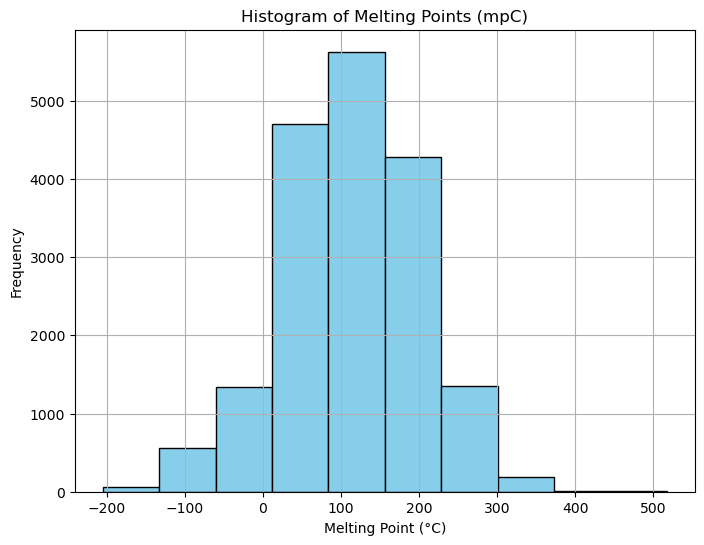

In [5]:
# Plot a histogram of the melting points
plt.figure(figsize=(8, 6))
plt.hist(selected_compounds['mpC'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Melting Points (mpC)')
plt.xlabel('Melting Point (°C)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


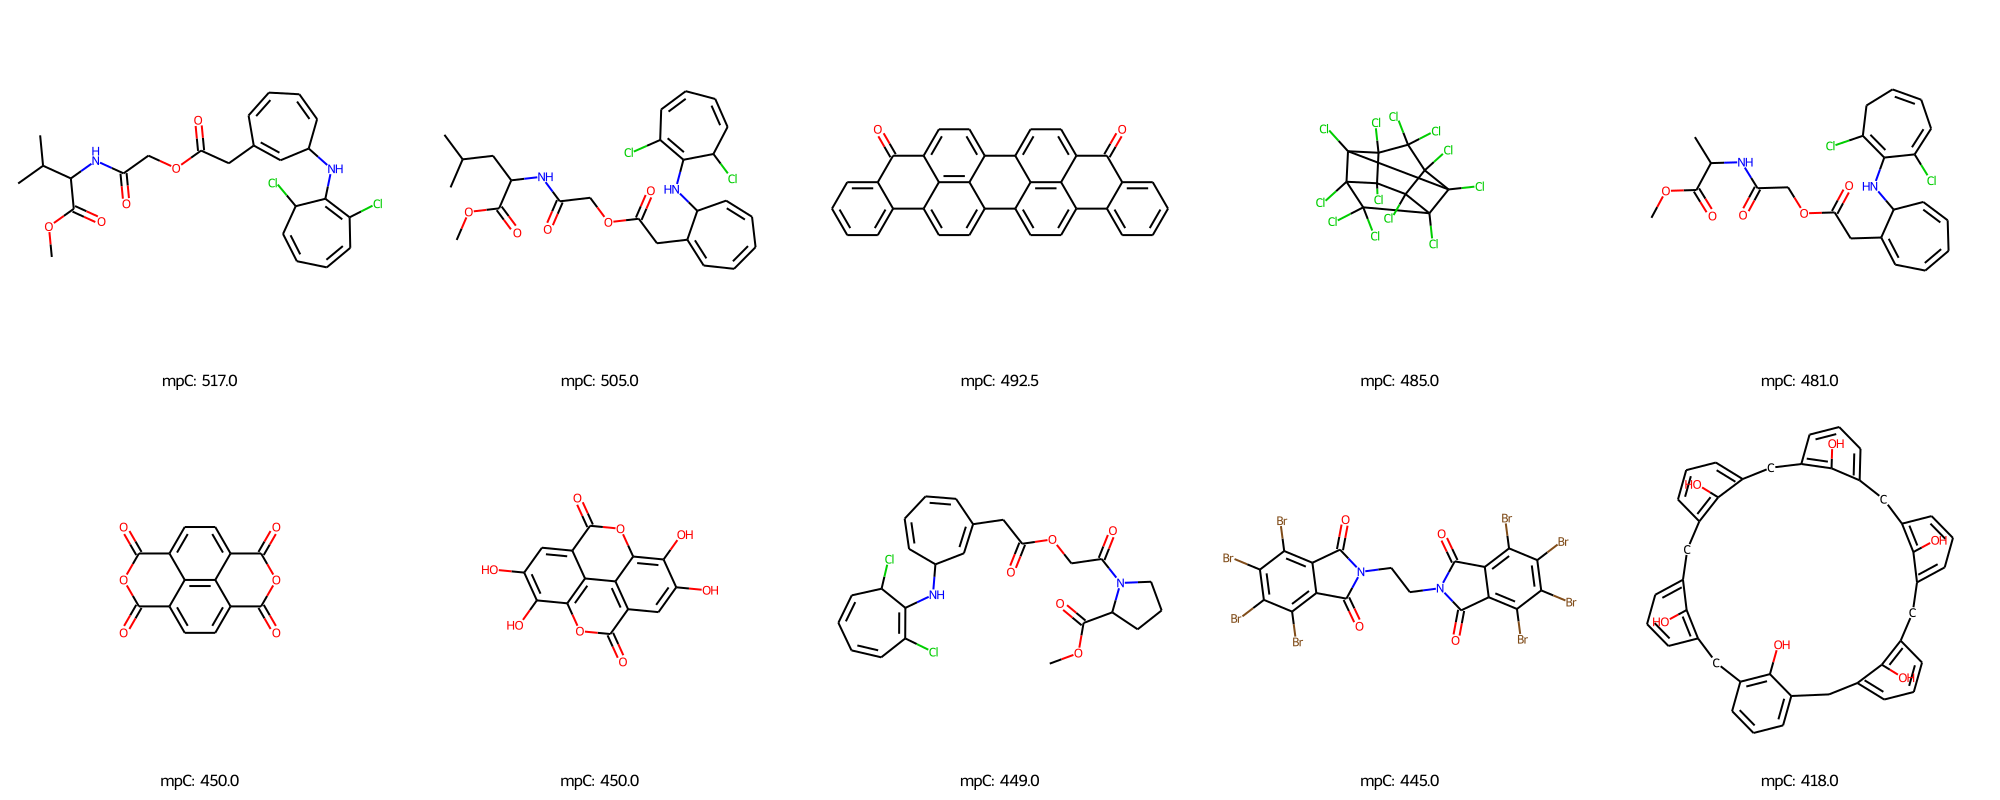

In [6]:
# Number of molecules to display
number_of_molecules_to_display = 10

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = selected_compounds.sort_values(by='mpC', ascending=False)

# Get the top molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects for the SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Create legend text with melting point values
legend_texts = [f"mpC: {mp}" for mp in top_molecules['mpC']]

# Draw the molecules in a grid with legend
img = Draw.MolsToGridImage(mols, legends=legend_texts, molsPerRow=5, subImgSize=(400, 400))

# Display the image
display(img)

In [8]:
# Function to calculate all Mordred descriptors for a given SMILES string
def calculate_all_mordred_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    calc = Calculator(descriptors)
    mordred_descriptors = calc(mol)
    return mordred_descriptors.fill_missing().asdict()

# List to store dictionaries of descriptors for each molecule
descriptor_dicts = []

# Iterate over each SMILES string and calculate descriptors
for smiles in selected_compounds['smiles']:
    descriptor_dict = calculate_all_mordred_descriptors(smiles)
    descriptor_dicts.append(descriptor_dict)

# Convert the list of dictionaries into a DataFrame
df_descriptors = pd.DataFrame(descriptor_dicts)

/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyboardInterrupt: 

In [ ]:
# Reset the indices of df and df_descriptors
selected_compounds.reset_index(drop=True, inplace=True)
df_descriptors.reset_index(drop=True, inplace=True)

# Concatenate df and df_descriptors along the columns axis (axis=1)
df_combined = pd.concat([selected_compounds, df_descriptors], axis=1)

In [ ]:
# Save df_combined as an Excel file
df_combined.to_excel('FONCl_descriptors.xlsx', index=False)

In [101]:
#Drop low variance features
# Calculate variance for each column
variances = X.var()

# Set a threshold for variance
threshold = 0.05  # You can adjust this threshold based on your preference

# Initialize the VarianceThreshold transformer
selector = VarianceThreshold(threshold)

# Fit the transformer to your data (finds low-variance features)
selector.fit(X)

# Get the indices of the features that are being kept
kept_indices = selector.get_support(indices=True)

# Filter the original DataFrame to keep only the high-variance columns
X = X.iloc[:, kept_indices]
X.shape

(302, 480)

In [109]:
#Drop higly correlated features
# Calculate the correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X = X.drop(to_drop, axis=1)
X.shape

(302, 91)

In [110]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [111]:
#Initiate the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [112]:
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=16)


Epoch 1/100


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 6582.1108 - mae: 68.2516 - val_loss: 6441.3569 - val_mae: 73.0990
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7686.3667 - mae: 74.1595 - val_loss: 6217.4116 - val_mae: 71.4876
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6735.1362 - mae: 68.9079 - val_loss: 5800.4858 - val_mae: 68.3391
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5725.1182 - mae: 64.8784 - val_loss: 5079.5957 - val_mae: 63.0549
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5049.8677 - mae: 58.5093 - val_loss: 4065.6506 - val_mae: 54.4361
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3130.2517 - mae: 47.0829 - val_loss: 3169.6326 - val_mae: 41.3766
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1916.4255 - mae: 34.9838 - val_loss: 2767.3933 - val_mae: 35.3003
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1358.5768 - mae: 28.4175 - val_loss: 2343.3464 - val_mae: 31.1881
Epoch 9/

In [113]:
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {test_mae}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 287.3330 - mae: 12.1020 
Test MAE: 12.375922203063965


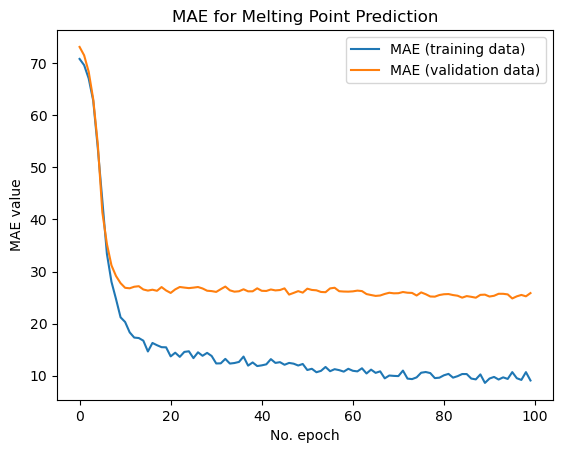

In [114]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['val_mae'], label='MAE (validation data)')
plt.title('MAE for Melting Point Prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
MSE: 297.90136576577254
R^2 score: 0.9440369753476292


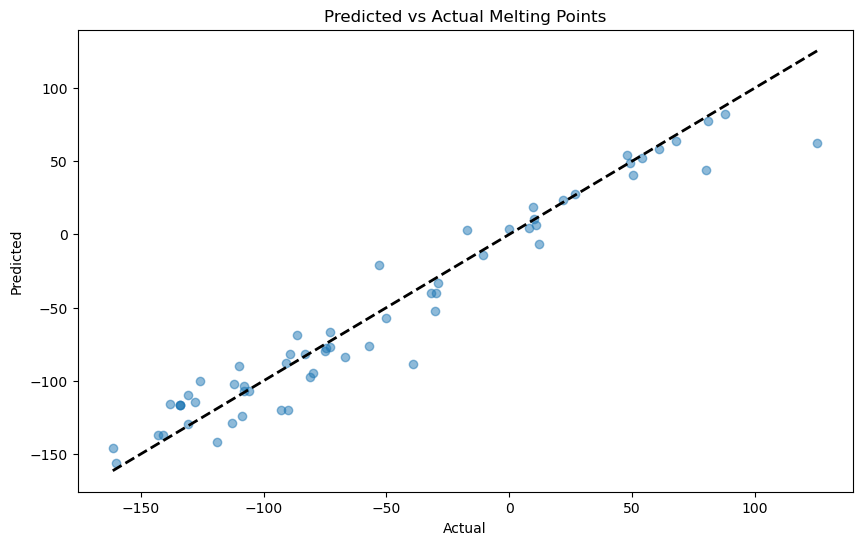

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test_scaled)

# Calculating MSE and R^2
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MSE: {mse}")
print(f"R^2 score: {r2}")

# Plotting Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Melting Points')
plt.show()


In [128]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(91,), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=5, min_lr=0.0001)

# Assuming you have `X_train`, `y_train`, `X_val`, and `y_val` already defined
model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 6937.8110 - mae: 70.5593 - val_loss: 8139.8350 - val_mae: 77.6013 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6934.2925 - mae: 70.9506 - val_loss: 7919.3076 - val_mae: 76.4927 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6633.6704 - mae: 68.3772 - val_loss: 7603.0664 - val_mae: 74.8630 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5853.4634 - mae: 64.8704 - val_loss: 7118.0068 - val_mae: 72.3163 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5436.0239 - mae: 61.9143 - val_loss: 6348.9492 - val_mae: 68.0941 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5158.7095 - mae: 59.8103 - val_loss: 5311.6172 - val_mae: 61.8787 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4381.7671 - mae: 53.5721 - val_loss: 4058.15

In [129]:
# Evaluate on validation data
val_loss, val_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Validation MAE: {val_mae}')

Validation MAE: 19.69385528564453


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
MSE: 866.8889475658927
R^2 score: 0.830884956363585


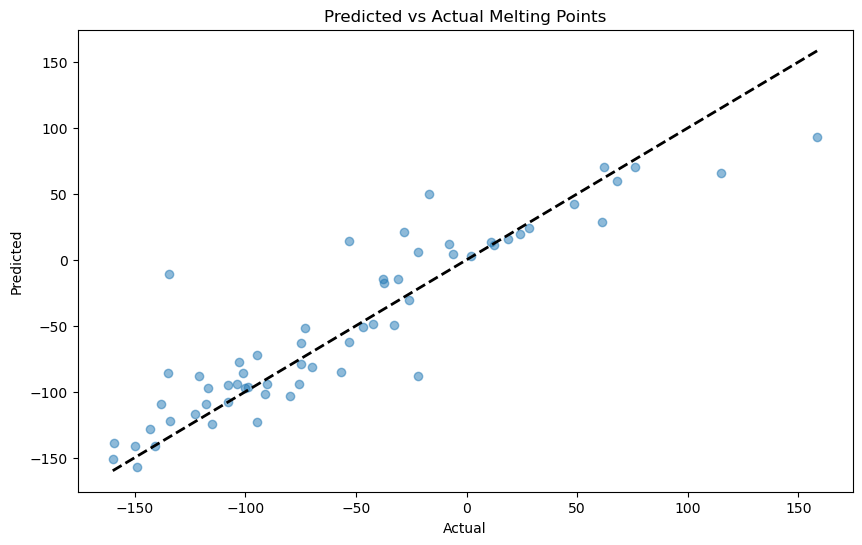

In [130]:
# Predict on validation data
predictions = model.predict(X_test_scaled)

# Assuming `X_test_scaled` is your scaled test set and `y_test` are the true melting point values
predictions = model.predict(X_test_scaled)

# Calculating MSE and R^2
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MSE: {mse}")
print(f"R^2 score: {r2}")

# Plotting Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Melting Points')
plt.show()

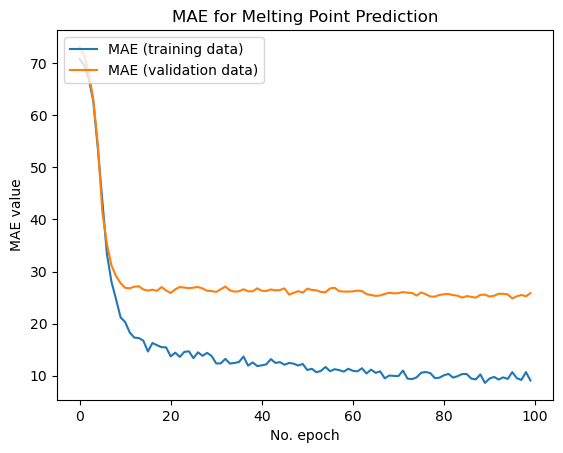

In [131]:
plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['val_mae'], label='MAE (validation data)')
plt.title('MAE for Melting Point Prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()